Total number of parameters: 44589
Epoch 10, Loss: 2.24403, Validation Loss: 2.44032, Validation Accuracy: 0.34249, Train Time: 0.07s,Validation Time: 0.0080s
Epoch 20, Loss: 1.78041, Validation Loss: 2.21983, Validation Accuracy: 0.39958, Train Time: 0.08s,Validation Time: 0.0093s
Epoch 30, Loss: 1.43281, Validation Loss: 2.09974, Validation Accuracy: 0.44397, Train Time: 0.07s,Validation Time: 0.0092s
Epoch 40, Loss: 1.11947, Validation Loss: 2.03665, Validation Accuracy: 0.45666, Train Time: 0.07s,Validation Time: 0.0101s
Epoch 50, Loss: 0.89183, Validation Loss: 2.08480, Validation Accuracy: 0.45666, Train Time: 0.07s,Validation Time: 0.0130s
Epoch 60, Loss: 0.62472, Validation Loss: 2.13392, Validation Accuracy: 0.49894, Train Time: 0.08s,Validation Time: 0.0074s
Epoch 70, Loss: 0.43275, Validation Loss: 2.25135, Validation Accuracy: 0.50529, Train Time: 0.07s,Validation Time: 0.0075s
Epoch 80, Loss: 0.28389, Validation Loss: 2.35641, Validation Accuracy: 0.51163, Train Time: 0.07s

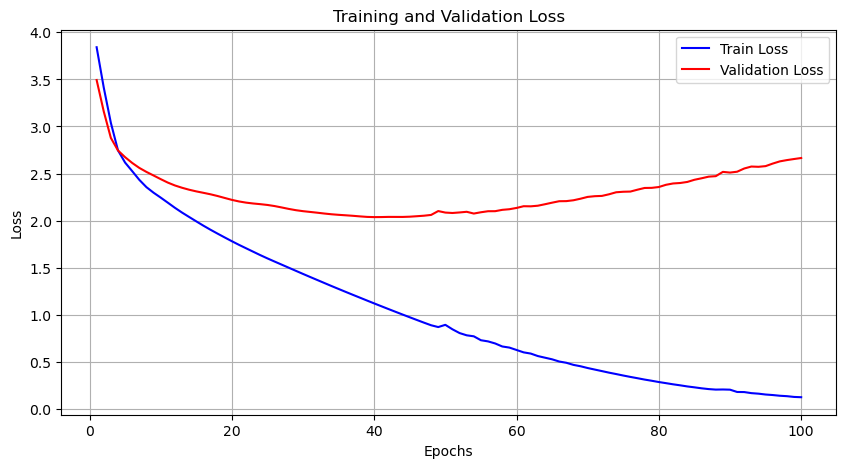

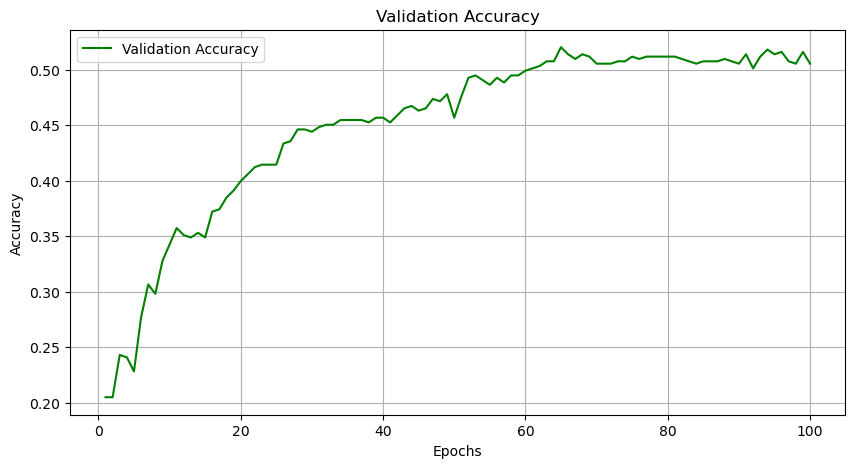

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.

Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.

Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.

In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology. """

chars = sorted(list(set(text)))

ix_to_char = {i: ch for i, ch in enumerate(chars)}

char_to_ix = {ch: i for i, ch in enumerate(chars)} 
chars = sorted(list(set(text)))

max_length = 30  
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  
        return output


hidden_size = 128
learning_rate = 0.005
epochs = 100


model = CharRNN(len(chars), hidden_size, len(chars))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

train_losses, val_losses, val_accuracies = [], [], []
total_start_time = time.time()
for epoch in range(epochs):
    train_start_time = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_end_time = time.time()
    train_time = train_end_time - train_start_time
    train_losses.append(loss)
    
   
    model.eval()
    with torch.no_grad():
        val_start_time = time.time()
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
        val_end_time = time.time()
        val_time=val_end_time - val_start_time
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():0.5f}, Validation Loss: {val_loss.item():0.5f}, Validation Accuracy: {val_accuracy.item():0.5f}, Train Time: {train_time:.2f}s,Validation Time: {val_time:.4f}s')

total_end_time = time.time()
total_execution_time = total_end_time - total_start_time
print(f"Total training time (including validation): {total_execution_time:.2f} seconds")   

train_losses = [loss.item() for loss in train_losses]
val_losses = [loss.item() for loss in val_losses]

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()



